In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data

import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

from convnet import DiscriminatorConvNet, GeneratorConvNet
from resnet import DiscriminatorResNet, GeneratorResNet
from utils import *


# Hyperparameters

Taken exactly from the paper.

In [3]:
num_gpu = 1
lr = 1e-4
beta1 = 0
beta2 = 0.9
num_epochs = 5000

dataroot="../data"
batch_size= 64
workers = 4
image_size= 48

real_label = 1
fake_label = -1

# Look for available GPU(s)
device = torch.device("cuda:0" if (torch.cuda.is_available() and num_gpu > 0) else "cpu")

# Sphere-GAN CONVNET Training

In [4]:
manual_seed = 333
random.seed(manual_seed)

torch.manual_seed(manual_seed)
genConv = GeneratorConvNet().to(device)

torch.manual_seed(manual_seed)
disConv = DiscriminatorConvNet().to(device)

torch.manual_seed(manual_seed)
genConv.apply(weights_init)
torch.manual_seed(manual_seed)
disConv.apply(weights_init)


DiscriminatorConvNet(
  (conv1_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (ln1_1): LayerNorm(torch.Size([64, 48, 48]), eps=1e-05, elementwise_affine=True)
  (lrelu1_1): LeakyReLU(negative_slope=0.2, inplace)
  (conv1_2): Conv2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (ln1_2): LayerNorm(torch.Size([64, 24, 24]), eps=1e-05, elementwise_affine=True)
  (lrelu1_2): LeakyReLU(negative_slope=0.2, inplace)
  (conv2_1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (ln2_1): LayerNorm(torch.Size([128, 24, 24]), eps=1e-05, elementwise_affine=True)
  (lrelu2_1): LeakyReLU(negative_slope=0.2, inplace)
  (conv2_2): Conv2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (ln2_2): LayerNorm(torch.Size([128, 12, 12]), eps=1e-05, elementwise_affine=True)
  (lrelu2_2): LeakyReLU(negative_slope=0.2, inplace)
  (conv3_1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), p

In [5]:
optimizerG = optim.Adam(genConv.parameters(), lr=lr, betas=(beta1, beta2))
optimizerD = optim.Adam(disConv.parameters(), lr=lr, betas=(beta1, beta2))

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, 128, device=device)
dataloader = get_stl10_dataloader(dataroot, batch_size, workers, image_size)
criterion = nn.BCELoss()

img_list = []
G_losses = []
D_losses = []
iters = 0
moments = 5

Files already downloaded and verified


In [6]:
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):

        ############################
        # (1) Update Discriminator
        ###########################
        disConv.zero_grad()
        label = torch.full((batch_size, 1), real_label, device=device)
        
        # Forward pass real batch through D
        output = disConv(data[0].to(device))
        
        # Calculate loss on all-real batch
        error_disc_real = total_moment_distance(output, label, moments, device) # criterion(output, label) #
        
        # Calculate gradients for D in backward pass
        error_disc_real.backward()

        ## Train with all-fake batch
        
        # Generate batch of latent vectors
        noise = torch.randn(batch_size, 128, device=device)
        
        # Generate fake image batch with G
        fake = genConv(noise)
        label.fill_(fake_label)
        
        # Classify all fake batch with D
        output = disConv(fake.detach())
        
        # Calculate D's loss on the all-fake batch
        error_disc_fake = total_moment_distance(output, label, moments, device) # criterion(output, label) #
        
        # Calculate the gradients for this batch
        error_disc_fake.backward()

        # Add the gradients from the all-real and all-fake batches
        error_disc = error_disc_real + error_disc_fake
        #error_disc.backward()
        
        # Update D
        optimizerD.step()

        ############################
        # (2) Update Generator
        ###########################
        genConv.zero_grad()
        
        label.fill_(real_label)  # fake labels are real for generator cost
        
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = disConv(fake)
        
        # Calculate G's loss based on this output
        error_gen = total_moment_distance(output, label, moments, device) # criterion(output, label)
        
        # Calculate gradients for G
        error_gen.backward()
        
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     error_disc.item(), error_gen.item()))

        # Save Losses for plotting later
        G_losses.append(error_gen.item())
        D_losses.append(error_disc.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = genConv(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
            
            plt.clf()
            plt.title("Fake Images")
            plt.imshow(np.transpose(img_list[-1],(1,2,0)))
            plt.savefig("../figures/fake_iter_{}.svg".format(iters))
            plt.clf()


        iters += 1

[0/5000][0/78]	Loss_D: 0.0003	Loss_G: 0.0081
[0/5000][50/78]	Loss_D: -0.0073	Loss_G: 0.0100
[1/5000][0/78]	Loss_D: -0.0113	Loss_G: 0.0137
[1/5000][50/78]	Loss_D: -0.0091	Loss_G: 0.0110
[2/5000][0/78]	Loss_D: -0.0187	Loss_G: 0.0270
[2/5000][50/78]	Loss_D: -0.0904	Loss_G: 0.0109
[3/5000][0/78]	Loss_D: -0.0096	Loss_G: 0.0112
[3/5000][50/78]	Loss_D: -0.0172	Loss_G: 0.0203
[4/5000][0/78]	Loss_D: -0.0127	Loss_G: 0.0144
[4/5000][50/78]	Loss_D: -0.0274	Loss_G: 0.0357
[5/5000][0/78]	Loss_D: -0.0163	Loss_G: 0.0190
[5/5000][50/78]	Loss_D: -0.2172	Loss_G: 0.0133
[6/5000][0/78]	Loss_D: -0.0359	Loss_G: 0.0925
[6/5000][50/78]	Loss_D: -0.0524	Loss_G: 0.1088
[7/5000][0/78]	Loss_D: -0.0162	Loss_G: 0.0176
[7/5000][50/78]	Loss_D: -0.0179	Loss_G: 0.0200
[8/5000][0/78]	Loss_D: -0.0237	Loss_G: 0.0262
[8/5000][50/78]	Loss_D: -0.0225	Loss_G: 0.0247
[9/5000][0/78]	Loss_D: -0.0258	Loss_G: 0.0287
[9/5000][50/78]	Loss_D: -0.0324	Loss_G: 0.0368
[10/5000][0/78]	Loss_D: -0.1131	Loss_G: 0.0417
[10/5000][50/78]	Loss_D:

[87/5000][0/78]	Loss_D: 0.0110	Loss_G: 0.1592
[87/5000][50/78]	Loss_D: -0.0044	Loss_G: 0.0407
[88/5000][0/78]	Loss_D: 0.0025	Loss_G: 0.0452
[88/5000][50/78]	Loss_D: 0.0014	Loss_G: 0.0114
[89/5000][0/78]	Loss_D: 0.0002	Loss_G: 0.0070
[89/5000][50/78]	Loss_D: -0.0016	Loss_G: 0.0325
[90/5000][0/78]	Loss_D: -0.0378	Loss_G: 0.1715
[90/5000][50/78]	Loss_D: 0.0031	Loss_G: 0.0778
[91/5000][0/78]	Loss_D: -0.0625	Loss_G: 0.1944
[91/5000][50/78]	Loss_D: -0.0125	Loss_G: 0.2039
[92/5000][0/78]	Loss_D: 0.0139	Loss_G: 0.3180


KeyboardInterrupt: 

<Figure size 432x288 with 0 Axes>

<Figure size 720x360 with 0 Axes>

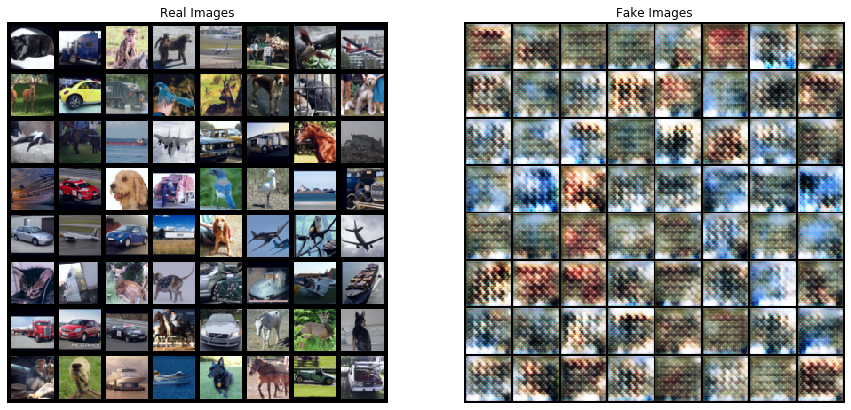

In [15]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.savefig('../figures/loss.svg')
plt.clf()

# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.savefig("../figures/real_vs_fake.svg")


# SphereGAN ResNet Training

In [8]:
manual_seed = 15
random.seed(manual_seed)

torch.manual_seed(manual_seed)
genResnet = GeneratorResNet().to(device)

torch.manual_seed(manual_seed)
disResnet = DiscriminatorResNet().to(device)

torch.manual_seed(manual_seed)
genResnet.apply(weights_init)

torch.manual_seed(manual_seed)
disResnet.apply(weights_init)


DiscriminatorResNet(
  (conv1): conv3x3(
    (conv): Conv2d(3, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (rb1): ResidualBlockDownSample(
    (avg_pool1): AdaptiveAvgPool2d(output_size=(24, 24))
    (conv_shortcut): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (relu1): LeakyReLU(negative_slope=0.2, inplace)
    (relu2): LeakyReLU(negative_slope=0.2, inplace)
    (ln1): LayerNorm(torch.Size([256, 48, 48]), eps=1e-05, elementwise_affine=True)
    (ln2): LayerNorm(torch.Size([256, 24, 24]), eps=1e-05, elementwise_affine=True)
    (conv_1): conv3x3(
      (conv): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (conv_2): conv3x3(
      (conv): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (avg_pool2): AdaptiveAvgPool2d(output_size=(24, 24))
  )
  (rb2): ResidualBlockDownSample(
    (avg_pool1): AdaptiveAvgPool2d(output_size=(12, 12))
    (conv_shortcut): Conv2d(256, 256, kerne

In [9]:
optimizerGenResnet = optim.Adam(genResnet.parameters(), lr=lr, betas=(beta1, beta2))
optimizerDiscResnet = optim.Adam(disResnet.parameters(), lr=lr, betas=(beta1, beta2))

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, 128, device=device)
dataloader_resnet = get_stl10_dataloader(dataroot, batch_size, workers, image_size)

img_list_resnet = []
G_losses_resnet = []
D_losses_resnet = []
iters_resnet = 0
moments_resnet = 3

Files already downloaded and verified


In [ ]:
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader_resnet, 0):

        ############################
        # (1) Update Discriminator
        ###########################
        disResnet.zero_grad()
        label = torch.full((batch_size,1), real_label, device=device)
        
        # Forward pass real batch through D
        output = disResnet(data[0].to(device))
        
        # Calculate loss on all-real batch
        error_disc_real = total_moment_distance(output, label, moments_resnet, device)
        
        # Calculate gradients for D in backward pass
        error_disc_real.backward()

        ## Train with all-fake batch
        
        # Generate batch of latent vectors
        noise = torch.randn(batch_size, 128, device=device)
        
        # Generate fake image batch with G
        fake = genResnet(noise)
        label.fill_(fake_label)
        
        # Classify all fake batch with D
        output = disResnet(fake.detach())
        
        # Calculate D's loss on the all-fake batch
        error_disc_fake = total_moment_distance(output, label, moments_resnet, device)
        
        # Calculate the gradients for this batch
        error_disc_fake.backward()

        # Add the gradients from the all-real and all-fake batches
        error_disc = error_disc_real + error_disc_fake
        #error_disc.backward()
        
        # Update D
        optimizerDiscResnet.step()

        ############################
        # (2) Update Generator
        ###########################
        genResnet.zero_grad()
        
        label.fill_(real_label)  # fake labels are real for generator cost
        
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = disResnet(fake)
        
        # Calculate G's loss based on this output
        error_gen = total_moment_distance(output, label, moments_resnet, device)
        
        # Calculate gradients for G
        error_gen.backward()
        
        # Update G
        optimizerGenResnet.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f'
                  % (epoch, num_epochs, i, len(dataloader_resnet),
                     error_disc.item(), error_gen.item()))

        # Save Losses for plotting later
        G_losses_resnet.append(error_gen.item())
        D_losses_resnet.append(error_disc.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters_resnet % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader_resnet)-1)):
            with torch.no_grad():
                fake = genResnet(fixed_noise).detach().cpu()
            img_list_resnet.append(vutils.make_grid(fake, padding=2, normalize=True))
            
            plt.clf()
            plt.title("Fake Images")
            plt.imshow(np.transpose(img_list_resnet[-1],(1,2,0)))
            plt.savefig("../figures/Resnet_fake_iter_{}.svg".format(iters_resnet))
            plt.clf()


        iters_resnet += 1

[0/5000][0/78]	Loss_D: 0.0001	Loss_G: 0.0029
[0/5000][50/78]	Loss_D: -0.0000	Loss_G: 0.0008
[1/5000][0/78]	Loss_D: -0.0008	Loss_G: 0.0035
[1/5000][50/78]	Loss_D: nan	Loss_G: nan
[2/5000][0/78]	Loss_D: nan	Loss_G: nan
